# Visualize the latent space of networks using UMAP

This notebook shows how to
- Compute network outputs at internal layers of the network
- Visualize those outputs using UMAP

Note that this notebook is set up to run on several layers, which may use a considerable amount of memory. If memory is a limiting factor, you can run the layers individually with slight modifications.

In [1]:
# reload modules before executing code in order to make development and debugging easier
%load_ext autoreload
%autoreload 2

In [2]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir, isfile
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import tensorflow as tf
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as colors


import constants
import utils
import encode as enc
import inference as inf
from split_dataset import load_split_dir

# Load data and model

In [4]:
# load full dataset
ds = utils.load_dataset(ds_name="gb1")

# load the train-tune-test split used to train the model
ds_split = load_split_dir("pub/splits/gb1/main")

# load model and open a session so we can get output at internal layers of the network
model_prefix = "pub/trained_models/gb1/gb1_cnn"
sess = inf.restore_sess(model_prefix)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from pub/trained_models/gb1/gb1_cnn


# Determine output tensor names at each layer
We need to know the names of the specific tensors in the TensorFlow execution graph that contain the outputs at each network layer. These tensor names can be obtained by using TensorBoard to examine the TensorFlow execution graph or by using the following bit of code, which prints all the tensor names. 

The tensors we want are the output tensors at each layer after the activation function has been applied. Because we use the LeakyRelu activation function, most of these tensors will have "LeakyRelu" in the name. 

In [5]:
# for op in sess.graph.get_operations():
#     for tensor in op.values():
#         print(tensor.name)

In [6]:
layer_names = ["input", "conv1", "conv2", "conv3", "dense"]
tensor_names = ["conv1/LeakyRelu:0", "conv2/LeakyRelu:0", "conv3/LeakyRelu:0", "dense1/LeakyRelu:0"]

# Compute the output at each layer

In [7]:
# only use the test set data
gb1_test_set_df = ds.iloc[ds_split["stest"]]
encoded_variants = enc.encode(encoding="one_hot,aa_index", variants=gb1_test_set_df["variant"].tolist(), ds_name="gb1")

outputs = []

for tn in tensor_names:
    # get the output for all variants at the specified output tensor name
    out = inf.run_inference(encoded_data=encoded_variants, sess=sess, output_tensor_name=tn)
    outputs.append(out)

100%|██████████| 838/838 [00:57<00:00, 14.52it/s]


# Apply UMAP to reduce dimensionality
This will give us two coordinates (x and y) for each variant at each layer.

In [8]:
def get_umap_embedding(network_outputs, umap_params):
    if len(network_outputs.shape) > 2:
        # if we have filter activations, need to flatten down to vector
        network_outputs = network_outputs.reshape(network_outputs.shape[0], -1)
    reducer = umap.UMAP(random_state=7, **umap_params)
    mapper = reducer.fit(network_outputs)
    embedding = mapper.transform(network_outputs)
    return mapper, embedding

In [9]:
# also compute the UMAP of the input sequences, before any transformation with the network
outputs_with_raw_seqs = [encoded_variants] + outputs

embeddings = []
for layer_name, layer_output in zip(layer_names, outputs_with_raw_seqs):
    print("Computing UMAP for layer: {}".format(layer_name))
    umap_params = {"n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean"}
    mapper, embedding = get_umap_embedding(layer_output, umap_params)
    embeddings.append(embedding)

Computing UMAP for layer: input
Computing UMAP for layer: conv1
Computing UMAP for layer: conv2
Computing UMAP for layer: conv3
Computing UMAP for layer: dense


# Plot the UMAP-transformed layer outputs

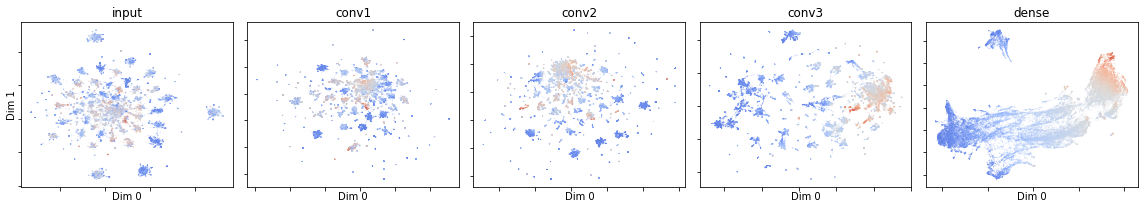

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=len(layer_names), figsize=(16, 3))
axes = axes.flatten()

for i in range(len(layer_names)):
    layer_name = layer_names[i]
    embedding = embeddings[i]
    ax = axes[i]
    divnorm = colors.TwoSlopeNorm(vmin=gb1_test_set_df["score"].min(), vcenter=0, vmax=gb1_test_set_df["score"].max())
    ax.scatter(embedding[:, 0], embedding[:, 1], c=gb1_test_set_df["score"], cmap="coolwarm", norm=divnorm,
               s=0.5, alpha=0.5, marker="o", linewidth=0)
    ax.set(title=layer_name, xlabel="Dim 0")
    ax.tick_params(labelbottom=False, labelleft=False)
    
axes[0].set(ylabel="Dim 1")

plt.tight_layout()
plt.show()
plt.close(fig)

# 